#### Code from https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate') # padding mode same as original Caffe code
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 970'

In [6]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.nn as nn
import numpy as np
import h5py
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [7]:
# learning parameters
batch_size = 64 # batch size, reduce if facing OOM error
epochs = 100 # number of epochs to train the SRCNN model for
lr = 0.001 # the learning rate
device = 'cuda'

In [8]:
# input image dimensions
img_rows, img_cols = 33, 33
out_rows, out_cols = 33, 33

In [9]:
file = h5py.File('input/train_mscale.h5')
# `in_train` has shape (21884, 33, 33, 1) which corresponds to
# 21884 image patches of 33 pixels height & width and 1 color channel
in_train = file['data'][:] # the training data
out_train = file['label'][:] # the training labels
file.close()
# change the values to float32
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

In [10]:
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Training samples:  16368
Validation samples:  5456


In [11]:
# the dataset module
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [12]:
# train and validation data
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [14]:
# initialize the model
print('Computation device: ', device)
model = SRCNN().to(device)
print(model)

Computation device:  cuda
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [17]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [19]:
# peak signal to noise ratio (MSE converted to dB)
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [24]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [25]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        save_image(outputs, f"outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [26]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 100


256it [00:03, 74.29it/s]                         
86it [00:00, 137.78it/s]                        


Train PSNR: 26.974
Val PSNR: 27.324
Epoch 2 of 100


256it [00:03, 80.57it/s]                         
86it [00:00, 138.56it/s]                        


Train PSNR: 27.081
Val PSNR: 27.409
Epoch 3 of 100


256it [00:03, 80.00it/s]                         
86it [00:00, 137.90it/s]                        


Train PSNR: 27.158
Val PSNR: 27.483
Epoch 4 of 100


256it [00:03, 80.28it/s]                         
86it [00:00, 138.57it/s]                        


Train PSNR: 27.218
Val PSNR: 27.540
Epoch 5 of 100


256it [00:03, 80.01it/s]                         
86it [00:00, 138.34it/s]                        


Train PSNR: 27.267
Val PSNR: 27.590
Epoch 6 of 100


256it [00:03, 80.65it/s]                         
86it [00:00, 138.56it/s]                        


Train PSNR: 27.298
Val PSNR: 27.625
Epoch 7 of 100


256it [00:03, 79.91it/s]                         
86it [00:00, 134.04it/s]                        


Train PSNR: 27.335
Val PSNR: 27.662
Epoch 8 of 100


256it [00:03, 80.55it/s]                         
86it [00:00, 138.35it/s]                        


Train PSNR: 27.351
Val PSNR: 27.687
Epoch 9 of 100


256it [00:03, 80.58it/s]                         
86it [00:00, 138.79it/s]                        


Train PSNR: 27.377
Val PSNR: 27.709
Epoch 10 of 100


256it [00:03, 80.77it/s]                         
86it [00:00, 139.01it/s]                        


Train PSNR: 27.393
Val PSNR: 27.727
Epoch 11 of 100


256it [00:03, 80.84it/s]                         
86it [00:00, 136.59it/s]                        


Train PSNR: 27.410
Val PSNR: 27.748
Epoch 12 of 100


256it [00:03, 80.80it/s]                         
86it [00:00, 138.62it/s]                        


Train PSNR: 27.423
Val PSNR: 27.757
Epoch 13 of 100


256it [00:03, 81.28it/s]                         
86it [00:00, 139.24it/s]                        


Train PSNR: 27.441
Val PSNR: 27.764
Epoch 14 of 100


256it [00:03, 80.28it/s]                         
86it [00:00, 127.48it/s]                        


Train PSNR: 27.461
Val PSNR: 27.785
Epoch 15 of 100


256it [00:03, 80.36it/s]                         
86it [00:00, 134.87it/s]                        


Train PSNR: 27.472
Val PSNR: 27.791
Epoch 16 of 100


256it [00:03, 80.94it/s]                         
86it [00:00, 137.90it/s]                        


Train PSNR: 27.486
Val PSNR: 27.791
Epoch 17 of 100


256it [00:03, 80.32it/s]                         
86it [00:00, 137.02it/s]                        


Train PSNR: 27.502
Val PSNR: 27.796
Epoch 18 of 100


256it [00:03, 80.47it/s]                         
86it [00:00, 136.80it/s]                        


Train PSNR: 27.515
Val PSNR: 27.792
Epoch 19 of 100


256it [00:03, 80.37it/s]                         
86it [00:00, 133.82it/s]                        


Train PSNR: 27.528
Val PSNR: 27.813
Epoch 20 of 100


256it [00:03, 79.32it/s]                         
86it [00:00, 140.79it/s]                        


Train PSNR: 27.538
Val PSNR: 27.880
Epoch 21 of 100


256it [00:03, 81.42it/s]                         
86it [00:00, 141.42it/s]                        


Train PSNR: 27.555
Val PSNR: 27.880
Epoch 22 of 100


256it [00:03, 81.78it/s]                         
86it [00:00, 141.30it/s]                        


Train PSNR: 27.577
Val PSNR: 27.889
Epoch 23 of 100


256it [00:03, 80.44it/s]                         
86it [00:00, 135.94it/s]                        


Train PSNR: 27.577
Val PSNR: 27.922
Epoch 24 of 100


256it [00:03, 80.50it/s]                         
86it [00:00, 139.01it/s]                        


Train PSNR: 27.592
Val PSNR: 27.902
Epoch 25 of 100


256it [00:03, 81.19it/s]                         
86it [00:00, 139.92it/s]                        


Train PSNR: 27.618
Val PSNR: 27.939
Epoch 26 of 100


256it [00:03, 81.29it/s]                         
86it [00:00, 139.01it/s]                        


Train PSNR: 27.616
Val PSNR: 27.955
Epoch 27 of 100


256it [00:03, 81.20it/s]                         
86it [00:00, 138.34it/s]                        


Train PSNR: 27.588
Val PSNR: 27.972
Epoch 28 of 100


256it [00:03, 80.63it/s]                         
86it [00:00, 139.46it/s]                        


Train PSNR: 27.668
Val PSNR: 27.994
Epoch 29 of 100


256it [00:03, 81.14it/s]                         
86it [00:00, 138.57it/s]                        


Train PSNR: 27.621
Val PSNR: 27.986
Epoch 30 of 100


256it [00:03, 81.14it/s]                         
86it [00:00, 138.57it/s]                        


Train PSNR: 27.683
Val PSNR: 27.951
Epoch 31 of 100


256it [00:03, 81.21it/s]                         
86it [00:00, 138.79it/s]                        


Train PSNR: 27.677
Val PSNR: 27.955
Epoch 32 of 100


256it [00:03, 81.11it/s]                         
86it [00:00, 133.62it/s]                        


Train PSNR: 27.685
Val PSNR: 27.959
Epoch 33 of 100


256it [00:03, 81.35it/s]                         
86it [00:00, 138.34it/s]                        


Train PSNR: 27.697
Val PSNR: 28.014
Epoch 34 of 100


256it [00:03, 81.12it/s]                         
86it [00:00, 139.47it/s]                        


Train PSNR: 27.676
Val PSNR: 28.044
Epoch 35 of 100


256it [00:03, 80.80it/s]                         
86it [00:00, 138.12it/s]                        


Train PSNR: 27.738
Val PSNR: 28.034
Epoch 36 of 100


256it [00:03, 80.90it/s]                         
86it [00:00, 136.59it/s]                        


Train PSNR: 27.727
Val PSNR: 28.056
Epoch 37 of 100


256it [00:03, 80.03it/s]                         
86it [00:00, 136.80it/s]                        


Train PSNR: 27.752
Val PSNR: 28.024
Epoch 38 of 100


256it [00:03, 80.33it/s]                         
86it [00:00, 136.37it/s]                        


Train PSNR: 27.719
Val PSNR: 28.106
Epoch 39 of 100


256it [00:03, 80.36it/s]                         
86it [00:00, 135.94it/s]                        


Train PSNR: 27.758
Val PSNR: 28.103
Epoch 40 of 100


256it [00:03, 80.34it/s]                         
86it [00:00, 136.15it/s]                        


Train PSNR: 27.762
Val PSNR: 28.111
Epoch 41 of 100


256it [00:03, 80.05it/s]                         
86it [00:00, 137.02it/s]                        


Train PSNR: 27.776
Val PSNR: 28.145
Epoch 42 of 100


256it [00:03, 80.33it/s]                         
86it [00:00, 135.64it/s]                        


Train PSNR: 27.781
Val PSNR: 28.162
Epoch 43 of 100


256it [00:03, 80.20it/s]                         
86it [00:00, 136.80it/s]                        


Train PSNR: 27.827
Val PSNR: 28.138
Epoch 44 of 100


256it [00:03, 80.45it/s]                         
86it [00:00, 135.94it/s]                        


Train PSNR: 27.775
Val PSNR: 28.151
Epoch 45 of 100


256it [00:03, 80.05it/s]                         
86it [00:00, 137.24it/s]                        


Train PSNR: 27.836
Val PSNR: 28.177
Epoch 46 of 100


256it [00:03, 80.20it/s]                         
86it [00:00, 137.46it/s]                        


Train PSNR: 27.817
Val PSNR: 28.185
Epoch 47 of 100


256it [00:03, 80.41it/s]                         
86it [00:00, 137.46it/s]                        


Train PSNR: 27.833
Val PSNR: 28.179
Epoch 48 of 100


256it [00:03, 80.21it/s]                         
86it [00:00, 138.15it/s]                        


Train PSNR: 27.862
Val PSNR: 28.156
Epoch 49 of 100


256it [00:03, 79.96it/s]                         
86it [00:00, 137.24it/s]                        


Train PSNR: 27.837
Val PSNR: 28.124
Epoch 50 of 100


256it [00:03, 80.60it/s]                         
86it [00:00, 137.68it/s]                        


Train PSNR: 27.881
Val PSNR: 28.095
Epoch 51 of 100


256it [00:03, 80.29it/s]                         
86it [00:00, 136.16it/s]                        


Train PSNR: 27.871
Val PSNR: 28.194
Epoch 52 of 100


256it [00:03, 80.14it/s]                         
86it [00:00, 135.29it/s]                        


Train PSNR: 27.884
Val PSNR: 28.160
Epoch 53 of 100


256it [00:03, 80.14it/s]                         
86it [00:00, 136.80it/s]                        


Train PSNR: 27.889
Val PSNR: 28.191
Epoch 54 of 100


256it [00:03, 79.90it/s]                         
86it [00:00, 136.93it/s]                        


Train PSNR: 27.923
Val PSNR: 28.241
Epoch 55 of 100


256it [00:03, 80.07it/s]                         
86it [00:00, 138.12it/s]                        


Train PSNR: 27.917
Val PSNR: 28.177
Epoch 56 of 100


256it [00:03, 80.30it/s]                         
86it [00:00, 138.12it/s]                        


Train PSNR: 27.917
Val PSNR: 28.282
Epoch 57 of 100


256it [00:03, 79.67it/s]                         
86it [00:00, 133.20it/s]                        


Train PSNR: 27.894
Val PSNR: 28.202
Epoch 58 of 100


256it [00:03, 79.86it/s]                         
86it [00:00, 135.29it/s]                        


Train PSNR: 27.942
Val PSNR: 28.292
Epoch 59 of 100


256it [00:03, 79.99it/s]                         
86it [00:00, 137.90it/s]                        


Train PSNR: 27.938
Val PSNR: 28.229
Epoch 60 of 100


256it [00:03, 80.70it/s]                         
86it [00:00, 137.68it/s]                        


Train PSNR: 27.930
Val PSNR: 28.216
Epoch 61 of 100


256it [00:03, 80.56it/s]                         
86it [00:00, 137.90it/s]                        


Train PSNR: 27.925
Val PSNR: 28.320
Epoch 62 of 100


256it [00:03, 79.95it/s]                         
86it [00:00, 138.12it/s]                        


Train PSNR: 27.951
Val PSNR: 28.284
Epoch 63 of 100


256it [00:03, 80.78it/s]                         
86it [00:00, 137.46it/s]                        


Train PSNR: 27.978
Val PSNR: 28.244
Epoch 64 of 100


256it [00:03, 80.66it/s]                         
86it [00:00, 138.34it/s]                        


Train PSNR: 27.940
Val PSNR: 28.281
Epoch 65 of 100


256it [00:03, 80.79it/s]                         
86it [00:00, 137.68it/s]                        


Train PSNR: 27.959
Val PSNR: 28.260
Epoch 66 of 100


256it [00:03, 80.05it/s]                         
86it [00:00, 136.37it/s]                        


Train PSNR: 27.979
Val PSNR: 28.312
Epoch 67 of 100


256it [00:03, 80.38it/s]                         
86it [00:00, 137.68it/s]                        


Train PSNR: 27.977
Val PSNR: 28.342
Epoch 68 of 100


256it [00:03, 80.96it/s]                         
86it [00:00, 132.47it/s]                        


Train PSNR: 27.996
Val PSNR: 28.332
Epoch 69 of 100


256it [00:03, 79.30it/s]                         
86it [00:00, 139.24it/s]                        


Train PSNR: 28.002
Val PSNR: 28.351
Epoch 70 of 100


256it [00:03, 79.70it/s]                         
86it [00:00, 139.69it/s]                        


Train PSNR: 27.993
Val PSNR: 28.221
Epoch 71 of 100


256it [00:03, 81.12it/s]                         
86it [00:00, 131.57it/s]                        


Train PSNR: 27.984
Val PSNR: 28.363
Epoch 72 of 100


256it [00:03, 77.73it/s]                         
86it [00:00, 128.62it/s]                        


Train PSNR: 27.975
Val PSNR: 28.314
Epoch 73 of 100


256it [00:03, 78.40it/s]                         
86it [00:00, 133.41it/s]                        


Train PSNR: 27.980
Val PSNR: 28.315
Epoch 74 of 100


256it [00:03, 79.41it/s]                         
86it [00:00, 134.24it/s]                        


Train PSNR: 28.010
Val PSNR: 28.390
Epoch 75 of 100


256it [00:03, 79.54it/s]                         
86it [00:00, 139.24it/s]                        


Train PSNR: 27.997
Val PSNR: 28.386
Epoch 76 of 100


256it [00:03, 81.00it/s]                         
86it [00:00, 138.34it/s]                        


Train PSNR: 28.024
Val PSNR: 28.310
Epoch 77 of 100


256it [00:03, 79.73it/s]                         
86it [00:00, 137.90it/s]                        


Train PSNR: 28.027
Val PSNR: 28.395
Epoch 78 of 100


256it [00:03, 79.80it/s]                         
86it [00:00, 137.24it/s]                        


Train PSNR: 28.022
Val PSNR: 28.254
Epoch 79 of 100


256it [00:03, 80.15it/s]                         
86it [00:00, 137.69it/s]                        


Train PSNR: 28.057
Val PSNR: 28.225
Epoch 80 of 100


256it [00:03, 80.17it/s]                         
86it [00:00, 132.38it/s]                        


Train PSNR: 28.021
Val PSNR: 28.366
Epoch 81 of 100


256it [00:03, 79.11it/s]                         
86it [00:00, 134.03it/s]                        


Train PSNR: 28.039
Val PSNR: 28.312
Epoch 82 of 100


256it [00:03, 78.83it/s]                         
86it [00:00, 131.17it/s]                        


Train PSNR: 28.031
Val PSNR: 28.423
Epoch 83 of 100


256it [00:03, 79.40it/s]                         
86it [00:00, 135.29it/s]                        


Train PSNR: 28.040
Val PSNR: 28.393
Epoch 84 of 100


256it [00:03, 80.32it/s]                         
86it [00:00, 137.24it/s]                        


Train PSNR: 28.036
Val PSNR: 28.409
Epoch 85 of 100


256it [00:03, 78.81it/s]                         
86it [00:00, 133.00it/s]                        


Train PSNR: 28.055
Val PSNR: 28.339
Epoch 86 of 100


256it [00:03, 79.28it/s]                         
86it [00:00, 131.37it/s]                        


Train PSNR: 28.069
Val PSNR: 28.375
Epoch 87 of 100


256it [00:03, 80.40it/s]                         
86it [00:00, 138.57it/s]                        


Train PSNR: 28.044
Val PSNR: 28.431
Epoch 88 of 100


256it [00:03, 80.40it/s]                         
86it [00:00, 133.41it/s]                        


Train PSNR: 28.088
Val PSNR: 28.425
Epoch 89 of 100


256it [00:03, 79.99it/s]                         
86it [00:00, 137.02it/s]                        


Train PSNR: 28.061
Val PSNR: 28.286
Epoch 90 of 100


256it [00:03, 78.20it/s]                         
86it [00:00, 135.29it/s]                        


Train PSNR: 28.072
Val PSNR: 28.338
Epoch 91 of 100


256it [00:03, 79.18it/s]                         
86it [00:00, 136.81it/s]                        


Train PSNR: 28.085
Val PSNR: 28.451
Epoch 92 of 100


256it [00:03, 79.29it/s]                         
86it [00:00, 136.15it/s]                        


Train PSNR: 28.076
Val PSNR: 28.355
Epoch 93 of 100


256it [00:03, 79.03it/s]                         
86it [00:00, 129.59it/s]                        


Train PSNR: 28.065
Val PSNR: 28.430
Epoch 94 of 100


256it [00:03, 80.04it/s]                         
86it [00:00, 139.69it/s]                        


Train PSNR: 28.116
Val PSNR: 28.440
Epoch 95 of 100


256it [00:03, 80.78it/s]                         
86it [00:00, 139.69it/s]                        


Train PSNR: 28.055
Val PSNR: 28.295
Epoch 96 of 100


256it [00:03, 81.28it/s]                         
86it [00:00, 133.20it/s]                        


Train PSNR: 28.093
Val PSNR: 28.445
Epoch 97 of 100


256it [00:03, 79.14it/s]                         
86it [00:00, 131.78it/s]                        


Train PSNR: 28.093
Val PSNR: 28.383
Epoch 98 of 100


256it [00:03, 79.23it/s]                         
86it [00:00, 135.94it/s]                        


Train PSNR: 28.088
Val PSNR: 28.441
Epoch 99 of 100


256it [00:03, 79.38it/s]                         
86it [00:00, 135.09it/s]                        


Train PSNR: 28.105
Val PSNR: 28.465
Epoch 100 of 100


256it [00:03, 80.35it/s]                         
86it [00:00, 137.46it/s]                        

Train PSNR: 28.078
Val PSNR: 28.467
Finished training in: 6.393 minutes


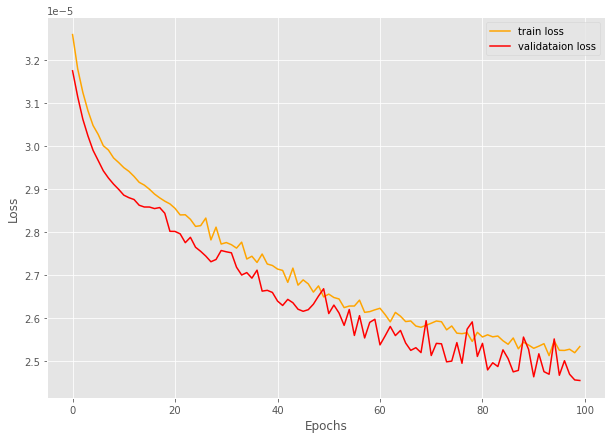

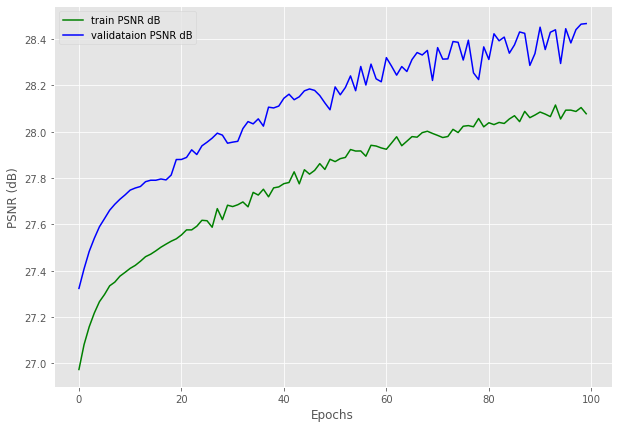

Saving model...


In [27]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss.png')
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.savefig('outputs/psnr.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'outputs/model.pth')

# Testing model

In [1]:
import torch
import cv2
import numpy as np
import glob as glob
import os
from torchvision.utils import save_image

In [2]:
device = 'cuda'

In [5]:
model = SRCNN().to(device)
model.load_state_dict(torch.load('outputs/model.pth'))

<All keys matched successfully>

In [6]:
image_paths = glob.glob('input/bicubic_2x/*')
for image_path in image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    test_image_name = image_path.split(os.path.sep)[-1].split('.')[0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(image.shape[0], image.shape[1], 1)
    cv2.imwrite(f"outputs/test_{test_image_name}.png", image)
    image = image / 255. # normalize the pixel values
    cv2.imshow('Greyscale image', image)
    cv2.waitKey(0)
    model.eval()
    with torch.no_grad():
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).to(device)
        image = image.unsqueeze(0)
        outputs = model(image)
    outputs = outputs.cpu()
    save_image(outputs, f"outputs/output_{test_image_name}.png")
    outputs = outputs.detach().numpy()
    outputs = outputs.reshape(outputs.shape[2], outputs.shape[3], outputs.shape[1])
    print(outputs.shape)
    cv2.imshow('Output', outputs)
    cv2.waitKey(0)

(504, 504, 1)
(288, 288, 1)
(252, 252, 1)
(276, 276, 1)
(336, 228, 1)
